In [1]:
# This script:
# 1. Imports required modules
# 2. Loads raw dataset
# 3. Performs K-fold cross validation and Selects SHAP-important features inside each fold
# 4. Calculates CV metrics using important features
# 5. Aggregate stable SHAP features
# 5. Optimizes classification threshold (Recall-focused)
# 6. Confusion matrix and ROC curve
# 7. Trains final production mode

# ===============================
# 1. Imports
# ===============================
import pandas as pd
import numpy as np
import shap
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import json

/home/bobur/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ===============================
# 2. Load dataset
# ===============================
df = pd.read_csv("TZ.csv")

TARGET = "ушел_из_банка"
DROP_COLS = ["ID", "ID_клиента", "фамилия"]

X = df.drop(columns=DROP_COLS + [TARGET])
y = df[TARGET].astype(int)

categorical_features = [
    "город",
    "пол",
    "активный_клиент",
    "есть_кредитка"
]

for col in categorical_features:
    X[col] = X[col].astype(str)

In [3]:
# ===========================================
# 3. CV setup with SHAP feature selection
# ===========================================
N_SPLITS = 10
SHAP_CUMSUM = 0.95

# stability threshold
MIN_FOLD_OCCURRENCE = int(0.5 * N_SPLITS)  # e.g. ≥5 folds

kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

oof_probs = np.zeros(len(y))
oof_true = np.zeros(len(y))

selected_features_per_fold = []
scores_roc_auc = []
scores_pr_auc = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n🔹 Fold {fold + 1}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # ---- Train base model (ALL features)
    base_model = CatBoostClassifier(
        iterations=500,
        depth=6,
        learning_rate=0.05,
        loss_function="Logloss",
        cat_features=categorical_features,
        verbose=0,
        random_state=42
    )
    base_model.fit(X_train, y_train)

    # ---- SHAP on TRAIN only
    explainer = shap.TreeExplainer(base_model)
    shap_values = explainer(X_train)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    shap_df = (
        pd.DataFrame({
            "feature": X_train.columns,
            "importance": mean_abs_shap
        })
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )

    shap_df["cumsum_ratio"] = (
        shap_df["importance"].cumsum() / shap_df["importance"].sum()
    )

    fold_features = shap_df.loc[
        shap_df["cumsum_ratio"] <= SHAP_CUMSUM, "feature"
    ].tolist()

    if len(fold_features) < 5:
        fold_features = shap_df["feature"].head(5).tolist()

    selected_features_per_fold.append(fold_features)

    print(f"Selected top features for this fold: {len(fold_features)}")
    print(fold_features)

    # ---- Reduced datasets. Only top features
    X_train_sel = X_train[fold_features]
    X_val_sel = X_val[fold_features]

    sel_cat_features = [f for f in fold_features if f in categorical_features]

    pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    final_model = CatBoostClassifier(
        iterations=600,
        depth=6,
        learning_rate=0.05,
        loss_function="Logloss",
        class_weights=[1, pos_weight],
        cat_features=sel_cat_features,
        verbose=0,
        random_state=42
    )

    final_model.fit(X_train_sel, y_train)
    oof_probs[val_idx] = final_model.predict_proba(X_val_sel)[:, 1]
    oof_true[val_idx] = y_val
    score_roc_auc = roc_auc_score(oof_true, oof_probs)
    score_pr_auc = average_precision_score(oof_true, oof_probs)
    scores_roc_auc.append(round(float(score_roc_auc), 4))
    scores_pr_auc.append(round(float(score_pr_auc), 4))


🔹 Fold 1
Selected top features for this fold: 7
['число_продуктов', 'возраст', 'активный_клиент', 'пол', 'город', 'баланс_депозита', 'кредитный_рейтинг']

🔹 Fold 2
Selected top features for this fold: 7
['число_продуктов', 'возраст', 'активный_клиент', 'пол', 'город', 'баланс_депозита', 'кредитный_рейтинг']

🔹 Fold 3
Selected top features for this fold: 7
['число_продуктов', 'возраст', 'активный_клиент', 'пол', 'город', 'баланс_депозита', 'кредитный_рейтинг']

🔹 Fold 4
Selected top features for this fold: 7
['число_продуктов', 'возраст', 'активный_клиент', 'пол', 'город', 'баланс_депозита', 'кредитный_рейтинг']

🔹 Fold 5
Selected top features for this fold: 7
['число_продуктов', 'возраст', 'активный_клиент', 'пол', 'город', 'баланс_депозита', 'кредитный_рейтинг']

🔹 Fold 6
Selected top features for this fold: 7
['число_продуктов', 'возраст', 'активный_клиент', 'пол', 'город', 'баланс_депозита', 'кредитный_рейтинг']

🔹 Fold 7
Selected top features for this fold: 7
['число_продуктов', '

In [4]:
# ==================================================================
# 4. K-Fold CV metrics (using top features when SHAP_CUMSUM = 0.95)
# ==================================================================

scores_roc_auc_mean = np.mean(scores_roc_auc)
scores_roc_auc_std = np.std(scores_roc_auc)
scores_pr_auc_mean = np.mean(scores_pr_auc)
scores_pr_auc_std = np.std(scores_pr_auc)

print("\nROC-AUC scores per fold:", scores_roc_auc)
print(f"Mean ROC-AUC: {scores_roc_auc_mean:.4f} ± {scores_roc_auc_std:.4f}")
print("\nPrecision per fold:", scores_pr_auc)
print(f"Mean precision: {scores_pr_auc_mean:.4f} ± {scores_pr_auc_std:.4f}")



ROC-AUC scores per fold: [0.9951, 0.9892, 0.9838, 0.9768, 0.9699, 0.9618, 0.9539, 0.9471, 0.9404, 0.9327]
Mean ROC-AUC: 0.9651 ± 0.0203

Precision per fold: [0.8381, 0.8366, 0.8428, 0.8353, 0.834, 0.8303, 0.8265, 0.8284, 0.8301, 0.8333]
Mean precision: 0.8335 ± 0.0047


In [5]:
# ===================================
# 5. Aggregate stable SHAP features
# ===================================
feature_counter = Counter(
    f for fold_feats in selected_features_per_fold for f in fold_feats
)

stable_features = [
    f for f, c in feature_counter.items()
    if c >= MIN_FOLD_OCCURRENCE
]

print("\n===============================")
print("Stable SHAP-selected features:")
print(stable_features)
print(f"Total stable features: {len(stable_features)}")
print("===============================")


Stable SHAP-selected features:
['число_продуктов', 'возраст', 'активный_клиент', 'пол', 'город', 'баланс_депозита', 'кредитный_рейтинг']
Total stable features: 7



Classification metrics at optimal threshold:

Optimal threshold
Threshold  : 0.196
ROC-AUC     : 0.933
Recall     : 0.939
F1-score   : 0.608
Final Recall: 0.939

Confusion Matrix:
TN FP
[8433 3509]
FN TP
[ 187 2871]


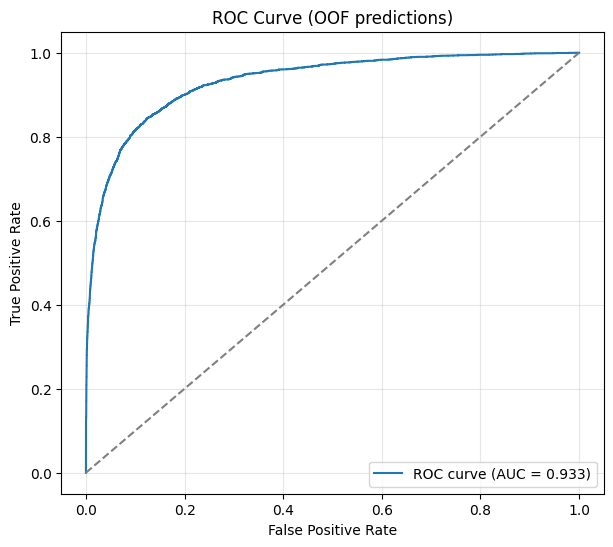

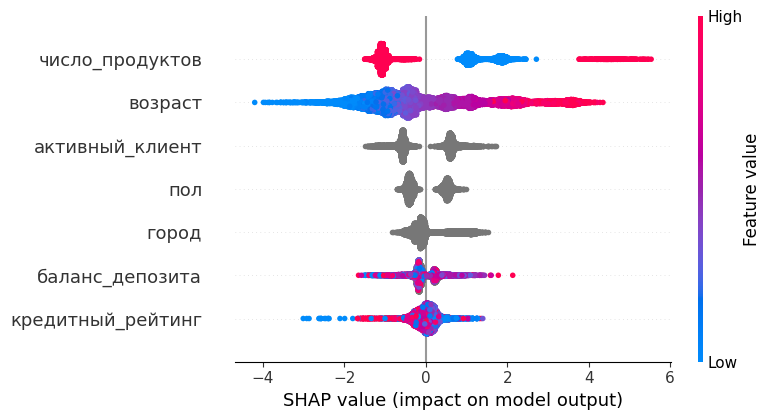

In [6]:
# ===========================================
# 6. Threshold optimization (Recall-focused)
# ===========================================
# Since we are using a 4:1 split between negative "0" and positive "1" target values,
# setting MIN_PRECISION = 0.45 means we're willing to accept nearly 2 false alarms
# for every 1 correct prediction. This is common in high-stakes fields where one would
# rather "investigate" a false alarm than "miss" a positive case.
# !!! Important note: precision ≠ accuracy of model

# ================================================================================ #
#    If the cost of False negative is too high, one need to keep threshold low     #
#    Threshold of 0.085 gives ~100 False negative and ~5500 False positive         #
#    Threshold of 0.196 gives ~190 False negative and ~3500 False positive         #
# ================================================================================ #

MIN_PRECISION = 0.45 ## Set manually from 0.30 to 0.40

precision, recall, thresholds = precision_recall_curve(oof_true, oof_probs)
valid = precision[:-1] >= MIN_PRECISION

best_idx = np.argmax(recall[:-1][valid])
best_threshold = thresholds[valid][best_idx]

y_pred = (oof_probs >= best_threshold).astype(int)
f1 = f1_score(oof_true, y_pred)
roc_auc = roc_auc_score(oof_true, oof_probs)

print("\nClassification metrics at optimal threshold:")
print("\nOptimal threshold")
print(f"Threshold  : {best_threshold:.3f}")
print(f"ROC-AUC     : {roc_auc:.3f}")
print(f"Recall     : {recall[:-1][valid][best_idx]:.3f}")
print(f"F1-score   : {f1:.3f}")
print(f"Final Recall: {recall_score(oof_true, y_pred):.3f}")

cm = confusion_matrix(oof_true, y_pred)
print("\nConfusion Matrix:")
print("TN FP")
print(cm[0])
print("FN TP")
print(cm[1])


# ===============================
# 7 ROC Curve (OOF)
# ===============================

fpr, tpr, roc_thresholds = roc_curve(oof_true, oof_probs)
roc_auc = roc_auc_score(oof_true, oof_probs)
f1 = f1_score(oof_true, y_pred)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOF predictions)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('ROC-curve_catboost')
plt.show()


# ==============================================================
# 8. Train final production model usig set of stable features
# ==============================================================
X_final = X[stable_features]
final_cat_features = [f for f in stable_features if f in categorical_features]

final_model = CatBoostClassifier(
    iterations=700,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    class_weights=[1, pos_weight],
    cat_features=final_cat_features,
    verbose=0,
    random_state=42
)

final_model.fit(X_final, y)

# ===============================
# 9. Final SHAP interpretation (safe)
# ===============================
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_final)

shap.summary_plot(shap_values, X_final)


In [7]:
# ===============================
# 10. Saving the artifacts
# ===============================

ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)

MODEL_PATH = ARTIFACT_DIR / "final_model.cbm"
final_model.save_model(MODEL_PATH)
print(f"Model saved to: {MODEL_PATH}")

FEATURES_PATH = ARTIFACT_DIR / "stable_features.json"
with open(FEATURES_PATH, "w", encoding="utf-8") as f:
    json.dump(stable_features, f, ensure_ascii=False, indent=2)
print(f"Stable features saved to: {FEATURES_PATH}")

THRESHOLD_PATH = ARTIFACT_DIR / "best_threshold.json"
threshold_artifact = {
    "threshold": float(best_threshold),
    "min_precision": MIN_PRECISION,
    "objective": "maximize_recall_given_precision_constraint"
}
with open(THRESHOLD_PATH, "w") as f:
    json.dump(threshold_artifact, f, indent=2)
print(f"Threshold saved to: {THRESHOLD_PATH}")

Model saved to: artifacts/final_model.cbm
Stable features saved to: artifacts/stable_features.json
Threshold saved to: artifacts/best_threshold.json
